In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize': (12,6)})

In [4]:
from market_instance import Stock, Market, GeoMarket, Segment
from environment import TradingEnvironment

In [5]:
N_STOCKS = 3

In [6]:
tickers = list(set(["".join([chr(int(np.random.random()*26+65)) for i in range(4)]) 
                    for i in range(2*N_STOCKS)]))[:N_STOCKS]
tickers

['UPJL', 'RXJX', 'KKRV']

# A Synthetic Market
Our synthetic market features a year with 256 trading days, that's four quarters of 64 trading days each. 

### Sentiments 
Sentiments are modeled as simple multipliers to the fundamental value of a stock. These multipliers basically come in the form of discontinuous sections of linear values in time. The discontuity stems from earnings surprises and other random events. ```rnd_sentiments``` provides some random parameters for these sections. Each quarter has its own linear section.

Stocks will inhibit a feature (method) called $\phi(t)$ that explicitly models the sentiment over time as we will see two cells from now.

In [7]:
def rnd_sentiments(s_max = 1, s_min = -10, n_quarters = 16):
    s_c = 0
    q = 64 # a quarter
    s = {0: (0, 0)}
    for i in range(n_quarters):
        dst = np.random.normal(.01, .1) / q
        day = i * q + int(np.random.normal(5))
        s[day] = (s_c, dst)
        s_c = min(s_max, s_c + np.random.normal(0, .2))
        s_c = max(s_min, s_c)
    s[1024] = (0,0)
    return s
#rnd_sentiments()

#### Geo market and segment influences (not really used yet)

In [8]:
# US market: bulls and bears
us = GeoMarket('US',                   # A name
               {0: (.1,0.001),         # Market sentiment over time, starting slightly bullish
                300: (-.1, 0),         # Not too bad yet
                400: (.2, -0.005),     # A period of hope
                500: (-.3,-.001),      # And dispair
                700: (-.2, 0.001)})    # Not really getting better.

# Segment sentiment: IT is calming down - the dawn of the new AI winter?
it = Segment('Information Technology', {0: (.0, 0)})

#### The stocks 
```psi(t)```, or $\Psi(t)$ is the *Expectation of the perceived value*. 

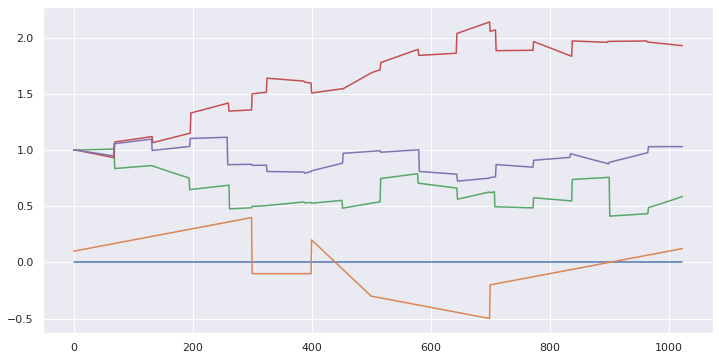

In [9]:
duration=1024
stocks = []
for ticker in tickers:
    E_cagr = np.random.normal(3e-2, 2e-2)   # expected compound annual growth rate
    max_effect = 3.0 # Maximum overrating due to sentiment
    psi0 = 50 + 20 * np.random.random() # initial price
    sentiments = rnd_sentiments()       # quarterly impacted stock sentiments
    beta_geo = np.random.normal(.0, .2)       # exposure (beta) to the US market
    stock = Stock(name=ticker, E_cagr=E_cagr, max_effect=max_effect, psi0 = psi0,
                    segments = {it: 1.0}, markets = {us: beta_geo},
                    sentiments = sentiments, noise=.4)
    stocks.append(stock)
#print(tickers)


plt.plot([it.phi(t) for t in range(duration)])
plt.plot([us.phi(t) for t in range(duration)])
plt.plot([stocks[0].psi(t)/stocks[0].psi(0) for t in range(duration)])
plt.plot([stocks[1].psi(t)/stocks[1].psi(0) for t in range(duration)])
plt.plot([stocks[2].psi(t)/stocks[2].psi(0) for t in range(duration)]);

#### Generating market history

In [10]:
market = Market(stocks=stocks, bid_ask=0.1)

config = {
    'num_investors': 10,
    'num_rounds_per_day': 5
}

holdings = {ticker: 10000 for ticker in tickers}
holdings['cash'] = 1e7

environment = TradingEnvironment(config, holdings, market, tx_cost=2.5e-3)

for _ in range(1024):
    market.open()
    daily = environment.let_others_trade()
    market.close()

period = 1024
fig = plt.figure(figsize=(16,12))
u = fig.add_subplot(3, 1, 1)
m = fig.add_subplot(3, 1, 2)
l = fig.add_subplot(3, 1, 3)
for ticker in tickers[0:1]:
    rel_prices = np.array(market.history[ticker][:period])[:,1]
    u.plot(rel_prices);
    u.plot([stocks[0].psi(t) for t in range(period)]);
for ticker in tickers[1:2]:
    rel_prices = np.array(market.history[ticker][:period])[:,1]
    m.plot(rel_prices);
    m.plot([stocks[1].psi(t) for t in range(period)]);
for ticker in tickers[2:3]:
    rel_prices = np.array(market.history[ticker][:period])[:,1]
    l.plot(rel_prices);
    l.plot([stocks[2].psi(t) for t in range(period)]);


KeyboardInterrupt: 

In [11]:
N_STOCKS = 5

In [ ]:
tickers = list(set(["".join([chr(int(np.random.random()*26+65)) for i in range(4)]) 
                    for i in range(2*N_STOCKS)]))[:N_STOCKS]

In [96]:
def save_a_package():
    for i in range(250):
        period = 1152
        stocks = {}
        for ticker in tickers:
            E_cagr = np.random.normal(3e-2, 2e-2)   # expected compound annual growth rate
            max_effect = 3.0 # Maximum overrating due to sentiment
            psi0 = 50 + 20 * np.random.random() # initial price
            sentiments = rnd_sentiments()       # quarterly impacted stock sentiments
            beta_geo = np.random.normal(.0, .2)       # exposure (beta) to the US market
            stock = Stock(name=ticker, E_cagr=E_cagr, max_effect=max_effect, psi0 = psi0,
                            segments = {it: 1.0}, markets = {us: beta_geo},
                            sentiments = sentiments, noise=.4)
            stocks[ticker] = stock

        market = Market(stocks=list(stocks.values()), bid_ask=0.1)

        config = {
            'num_investors': 10,
            'num_rounds_per_day': 5
        }

        holdings = {ticker: 10000 for ticker in tickers}
        holdings['cash'] = 1e7

        environment = TradingEnvironment(config, holdings, market, tx_cost=2.5e-3)

        for _ in range(period):
            market.open()
            daily = environment.let_others_trade()
            market.close()

        package = [
            [np.array(market.history[ticker][:duration])[:,1],
            [stocks[ticker].psi(t) for t in range(duration)]]
            for ticker in tickers]

        with open('charts.pkl', 'ab') as file:
            pickle.dump(package, file)
            
%time save_a_package()    

CPU times: user 1h 16min 27s, sys: 1min 46s, total: 1h 18min 14s
Wall time: 1h 17min 48s


In [82]:
np.shape(package)

(5, 2, 1152)

In [12]:
import pickle

In [13]:
mycharts = []

In [14]:
with open('../charts.pkl', 'rb') as file:
    while True:
        try: 
            mycharts.append(pickle.load(file))
        except EOFError:
            break;


In [15]:
np.shape(mycharts)

(253, 5, 2, 1152)

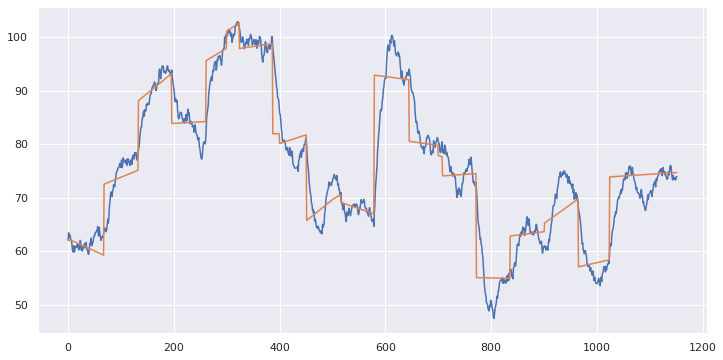

In [16]:
plt.plot(mycharts[51][3][0])
plt.plot(mycharts[51][3][1])

In [23]:
len(mycharts[51][3][0])

1152

In [24]:
c = mycharts[51][3][0]

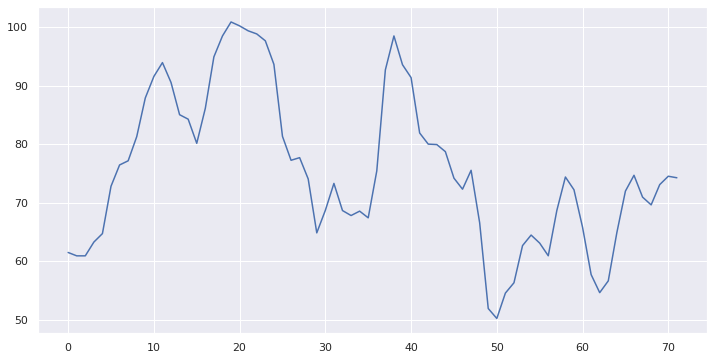

In [33]:
m4 = np.mean(np.reshape( c, [-1, 4]), axis=-1)
m8 = np.mean(np.reshape( c, [-1, 8]), axis=-1)
m16 = np.mean(np.reshape( c, [-1, 16]), axis=-1)
plt.plot(m16)

# Storyline

- Superior returns can only come from predicting the price
- Nobody can predict the future
- But one can predict the motion of a massive body in physics - inertia makes it possible.
- States of motion change, dependent on force and inertia.
- If the distribution of unpredictable forces has few large values, inertia may make a system predictable
- The slow change of human behaviour may manifest inertia in the market
- If there is that effect in the market - will it make some price movements predictable?
- Can we even observe oscillations and determine some kind of eigenfrequency at times?
- Note that the typical moving average signals try to exploit just that

My experiment introduces a a market that is carefully hand-crafted to exhibits inertia.

The market features assets that come with a function called *expected average perceived value*. This function is hard-coded. It changes over time mimicking quarterly earnings surprises with jumps in both directions. The perceived value can be sampled with noise for traders to act upon. 
Our market features a number of traders, each with two kinds of behaviour, differently balanced. Some prefer momentum stocks, they buy stocks that are moving upwards. Some prefer value stocks, they buy stocks that are currently traded below their average perceived value. These two *forces* create a dynamically stable system with stocks essentially oscillating around the perceived value. Note that this is the scenario described in the mean reversion theory.

The hypothesis I want to discuss is: 

#### If there is inertia present in a market, can it be exploited by price observation alone?

#### In our synthetic market, inertia is the only phenomenon that can be exploited.

#### Hence, if we find a successful algorithm in the synthetic market, and if there's inertia in the real market, then we can use this algorithm to make real money.

By using a synthetic market model, we control the left side of the if-clause!